# Big Picture

Kiva has given us multiple datasets in hopes that we can analyze and use the data to determine which regions should get the most amount of loans. This can be seen when they state: 
For the locations in which Kiva has active loans, your objective is to pair Kiva's data with additional data sources to estimate the welfare level of borrowers in specific regions, based on shared economic and demographic characteristics.

I want to turn this into a classification problem in which we can determine who is most likely to pay back the loans at different times. 

# Retreive the Data

## Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import model_selection

## Read the data

In [102]:
loans = pd.read_csv('kiva_loans.csv')
country_stats = pd.read_csv('kiva_country_profile_variables.csv')

# Visualization

First lets take a look at the demographics and statistics given to us from Kiva. Some key things to note are what we will be visualizing. Since the problem I'm approaching is a classification problem based on repayment intervals I will look at that visualized, funding amount, funded hour, sector, loan amount, and where the most loans went to. 

## Top sectors for loans

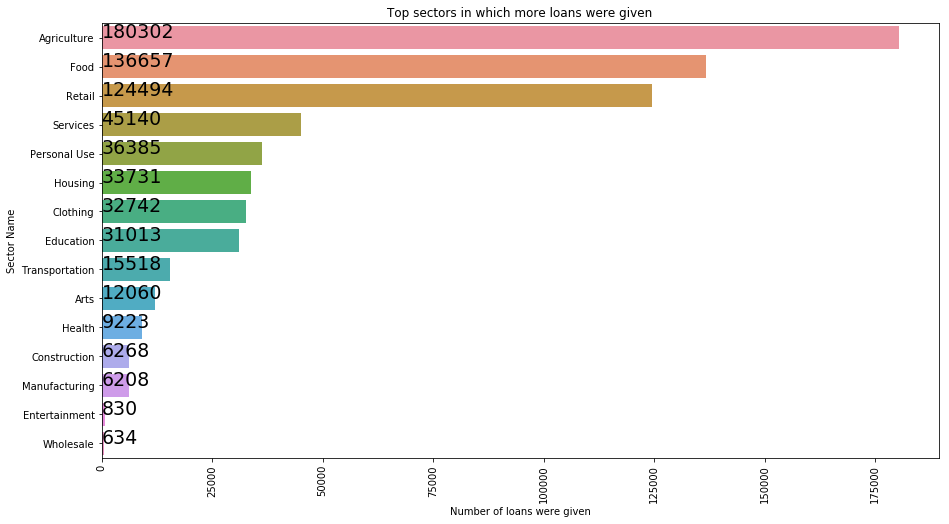

In [103]:
plt.figure(figsize=(15,8))
sector_name = loans['sector'].value_counts()
sns.barplot(sector_name.values, sector_name.index)
for i, v in enumerate(sector_name.values):
    plt.text(0.8,i,v,color='k',fontsize=19)
plt.xticks(rotation='vertical')
plt.xlabel('Number of loans were given')
plt.ylabel('Sector Name')
plt.title("Top sectors in which more loans were given")
plt.show()

Agriculture is the top sector for loans being given.

## Types of repayment Intervals

Text(0.5,1,'Types of repayment intervals with their count')

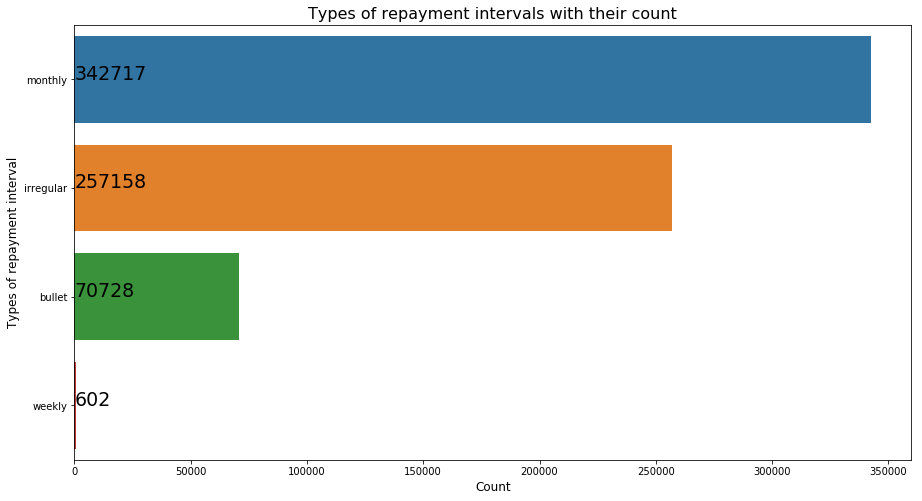

In [104]:
plt.figure(figsize=(15,8))
count = loans['repayment_interval'].value_counts().head(10)
sns.barplot(count.values, count.index, )
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=19)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Types of repayment interval', fontsize=12)
plt.title("Types of repayment intervals with their count", fontsize=16)

Monthly payment is the most common form of repayment. 

## Most frequent countries to received loans

Text(0.5,1,'Most frequent countries for kiva loan')

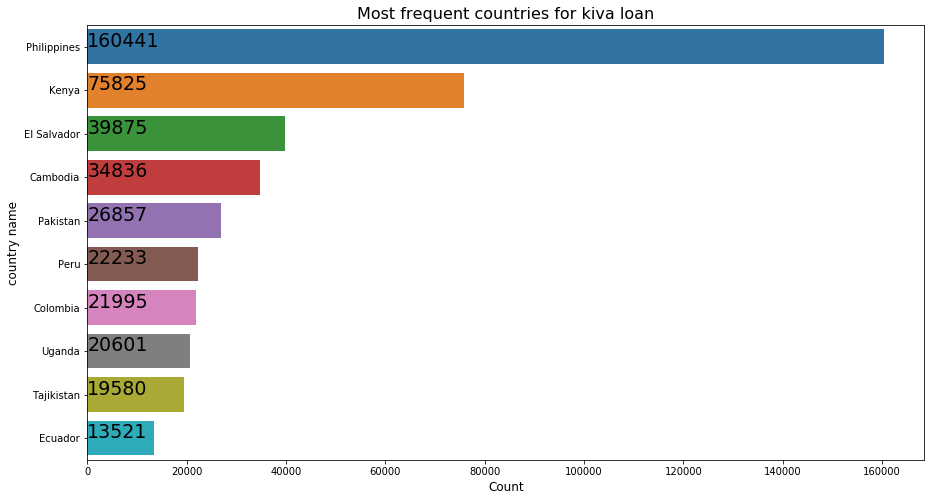

In [105]:
plt.figure(figsize=(15,8))
count = loans['country'].value_counts().head(10)
sns.barplot(count.values, count.index, )
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=19)
plt.xlabel('Count', fontsize=12)
plt.ylabel('country name', fontsize=12)
plt.title("Most frequent countries for kiva loan", fontsize=16)

Phillippines received the most loans

# Data Statistics

Now that we can visually see some of the statistics from the data, lets take a look at the features we will be using for our model and how those features can help us. We will mainly be pulling our data from the kiva_loans.csv file

In [106]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
id                    671205 non-null int64
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
use                   666973 non-null object
country_code          671197 non-null object
country               671205 non-null object
region                614405 non-null object
currency              671205 non-null object
partner_id            657698 non-null float64
posted_time           671205 non-null object
disbursed_time        668809 non-null object
funded_time           622874 non-null object
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  499789 non-null object
borrower_genders      666984 non-null object
repayment_interval    671205 non-null object
date                  671205 non

From the list of features the main ones that will be important to us are the ones containing numerical values: funded_amount, loan_amount, sector, posted_time, funded_time, and repayment_interval. You may be saying sector and repayment interval are catagorical values and posted time and funded time are date time features. What I will do is convert those catagorical features to numerical ones. Since we are classifying repayment interval and there are 4 types, we will encode them from 0-3. For sector i will look at which sectors are most common and give them the highest weights. There are 14 or 15 sectors so they will be from 0-14 with 14 being which ever sector is most common. For date time objects I will only use the hour they were lended instead of the entire object. This way we only use one integer.  

## Dimensionality Reduction

In [107]:
loans.drop(['id', 'use', 'disbursed_time','country_code', 'borrower_genders','activity','country', 'region', 'tags','currency', 'partner_id', 'date'], axis=1, inplace=True)

In [108]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 8 columns):
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
sector                671205 non-null object
posted_time           671205 non-null object
funded_time           622874 non-null object
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
repayment_interval    671205 non-null object
dtypes: float64(3), int64(1), object(4)
memory usage: 41.0+ MB


## Fill in any empty values

Now I will create a cloan of my dataset called object_loans and fill in any empty values. Furthermore I will change the objects in the dataset to datetime objects and eventually to ints. The goal is to have everything an int before running the model. 

In [109]:
object_loans = loans.select_dtypes(include=['object']).copy()

In [110]:
object_loans[object_loans.isnull().any(axis=1)]

,sector,posted_time,funded_time,repayment_interval
87,Housing,2014-01-02 09:53:45+00:00,NaN,monthly
112,Services,2014-01-02 09:44:10+00:00,NaN,monthly
186,Food,2014-01-02 09:35:12+00:00,NaN,monthly
309,Food,2014-01-02 09:51:47+00:00,NaN,monthly
313,Clothing,2014-01-02 10:03:18+00:00,NaN,monthly
648,Food,2014-01-03 10:39:51+00:00,NaN,monthly
747,Retail,2014-01-04 21:00:10+00:00,NaN,monthly
752,Retail,2014-01-04 20:42:54+00:00,NaN,monthly
796,Food,2014-01-04 21:16:02+00:00,NaN,monthly
811,Housing,2014-01-04 19:13:43+00:00,NaN,monthly


In [111]:
# Fill in funded time with most common entry
object_loans = object_loans.fillna({'funded_time': '2016-09-21 13:03:24+00:00'})

In [112]:
loans = object_loans
loans['posted_time'] = pd.to_datetime(loans['posted_time'])
loans['funded_time'] = pd.to_datetime(loans['funded_time'])
loans.dtypes # Successfully changed object types to datetime

sector                        object
posted_time           datetime64[ns]
funded_time           datetime64[ns]
repayment_interval            object
dtype: object

In [113]:
# Turn catagorical data into numerical data
cleanup_catagories = {"sector":             {'Agriculture': 14, 'Food': 13, 'Retail': 12, 'Services': 11, 'Personal Use': 10, 'Housing': 9, 'Clothing': 8, 'Education': 7, 'Transportation': 6, 'Arts': 5, 'Health': 4, 'Construction': 3, 'Manufacturing': 2, 'Entertainment': 1, 'Wholesale': 0},
                      "repayment_interval": {'weekly': 0, 'bullet': 1, 'irregular': 2, 'monthly': 3} }

In [114]:
loans.replace(cleanup_catagories, inplace=True)

In [115]:
# Now we need to extract only the hour value from datetime entries
loans['posted_time'] = loans['posted_time'].dt.hour
loans['funded_time'] = loans['funded_time'].dt.hour

In [117]:
loans # All values should be ints now

,sector,posted_time,funded_time,repayment_interval
0,13,6,10,2
1,6,6,9,2
2,6,9,16,1
3,5,8,13,2
4,13,11,19,3
5,11,10,14,2
6,14,9,17,1
7,11,11,18,3
8,2,11,18,3
9,13,5,15,2


In [118]:
loans.dtypes 

sector                int64
posted_time           int64
funded_time           int64
repayment_interval    int64
dtype: object

# Choosing a Classifier

Now that all of our values are ints, we can choose a classifier and run the model based on the above features. 

## Splitting the data

In [121]:
X = loans[['sector', 'posted_time', 'funded_time']]
Y = loans['repayment_interval']
validation_size = .20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

## Bagging

In [122]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, Y_train)
y_pred = bag_clf.predict(X_validation)

In [123]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_validation, y_pred))

0.6246005318792321


So as we can see we are getting terrible accuracy. 62%. Lets see if Decision Tree is any better

## Decision Tree

In [124]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, Y_train)
y_pred_tree = tree_clf.predict(X_validation)
print(accuracy_score(Y_validation, y_pred_tree))

0.6344410426024836


Slightly better at 63%. 

## Random Forest

In [125]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, Y_train)

y_pred_rf = rnd_clf.predict(X_validation)

In [126]:
print(accuracy_score(Y_validation, y_pred_rf))

0.6123836979760282


Worse than the other two. 

# AdaBoost

In [127]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, Y_train)
y_pred_aboost = ada_clf.predict(X_validation)
print(accuracy_score(Y_validation, y_pred_aboost))

0.6316550085294359


# Future

As we can see the models are not doing better than 63%. I think this is attributed to not enough features. Maybe I scaled down too many dimensions. To further this project I think i need more data. There are many applications for this classification project such as predicting the best time interval for repayment based on certain demographics. 